<a href="https://colab.research.google.com/github/kadaso/Prediction_of_gold_recovery_by_cyanidation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**


### **Description of the dataset**

## **Setup**

In [287]:
# Global variables
RANDOM_STATE = 42

# Modules
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)

# Scikit-Learn
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras import (layers, models)

libraries = (np, pd, sns, mpl, sklearn, tf, keras)
print("Imported libraries:")
for lib in libraries:
  print(f"{lib.__name__.capitalize()} v{lib.__version__}")

Imported libraries:
Numpy v1.22.4
Pandas v1.5.3
Seaborn v0.12.2
Matplotlib v3.7.1
Sklearn v1.2.2
Tensorflow v2.12.0
Keras.api._v2.keras v2.12.0


At the time of creating this notebook, the libraries that were used include:
+ Numpy v1.22.4
+ Pandas v1.5.3
+ Seaborn v0.12.2
+ Matplotlib v3.7.1
+ Sklearn v1.2.2
+ Tensorflow v2.12.0
+ Keras v2.12.0

## **Exploring the dataset**

In [288]:
from google.colab import drive
drive.mount(r"/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [289]:
dataset_path = r"/content/drive/MyDrive/Machine Learning/Optimization and prediction of gold cyanidation process/Dataset/leaching data.csv"
df = pd.read_csv(dataset_path)
df.head()

,Run,Wt pct ore 1,Sodium cyanide,Hydrogen peroxide,Initial pH,Final pH,Final cyanide,Dissolved oxygen,Recovery
0,1,58.7,500.0,500.0,10.70,8.70,76,5.3,89.91
1,2,75.0,826.6,500.0,11.29,8.61,6.5,5.8,90.35
2,3,91.3,500.0,500.0,10.67,7.48,<5,4.9,88.65
3,4,75.0,500.0,500.0,10.75,8.50,18,5.2,85.02
4,5,75.0,173.4,500.0,10.69,8.43,14,5.6,58.96


In [290]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head(3)

,run,wt_pct_ore_1,sodium_cyanide,hydrogen_peroxide,initial_ph,final_ph,final_cyanide,dissolved_oxygen,recovery
0,1,58.7,500.0,500.0,10.70,8.70,76,5.3,89.91
1,2,75.0,826.6,500.0,11.29,8.61,6.5,5.8,90.35
2,3,91.3,500.0,500.0,10.67,7.48,<5,4.9,88.65


In [291]:
print(f"Number of columns: {df.shape[1]}")
print(f"Number of experimental runs: {df.shape[0]}")

Number of columns: 9
Number of experimental runs: 20


In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   run                20 non-null     int64  
 1   wt_pct_ore_1       20 non-null     float64
 2   sodium_cyanide     20 non-null     float64
 3   hydrogen_peroxide  20 non-null     float64
 4   initial_ph         20 non-null     float64
 5   final_ph           20 non-null     float64
 6   final_cyanide      20 non-null     object 
 7   dissolved_oxygen   20 non-null     float64
 8   recovery           20 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.5+ KB


+ The column '*final_cyanide*' is incorrectly labeled to contain Python object data type instead of a numerical data type (i.e., floating-point value) due to the presence of '*less than 5 mg/L*' (i.e., <5 mg/L) data points that imply final concentration of cyanide species that could not be detected/ read/ measured during lab analysis.
+ In the next cell, these "<5" values will be converted to a very small number in order to finally have a floating-point value in the said column. In this case, 1e-5 (= 0.00001) will be used.

In [293]:
df["final_cyanide"] = df["final_cyanide"].str.replace("<5", "0.00001").astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   run                20 non-null     int64  
 1   wt_pct_ore_1       20 non-null     float64
 2   sodium_cyanide     20 non-null     float64
 3   hydrogen_peroxide  20 non-null     float64
 4   initial_ph         20 non-null     float64
 5   final_ph           20 non-null     float64
 6   final_cyanide      20 non-null     float64
 7   dissolved_oxygen   20 non-null     float64
 8   recovery           20 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 1.5 KB


In [294]:
print("Summary of statistics:\n")
df.drop("run", axis=1).describe().T

Summary of statistics:



,count,mean,std,min,25%,50%,75%,max
wt_pct_ore_1,20.0,75.000000,8.370940,58.70000,72.500000,75.000,77.5000,91.30
sodium_cyanide,20.0,500.000000,167.541844,173.40000,450.000000,500.000,550.0000,826.60
hydrogen_peroxide,20.0,500.000000,167.541844,173.40000,450.000000,500.000,550.0000,826.60
initial_ph,20.0,10.749500,0.185088,10.54000,10.617500,10.695,10.8200,11.29
final_ph,20.0,8.341500,0.563039,7.45000,8.047500,8.425,8.7175,9.20
final_cyanide,20.0,48.600003,81.073000,0.00001,4.875002,10.000,32.5000,242.00
dissolved_oxygen,20.0,5.280000,0.808898,3.90000,4.775000,5.300,5.8500,6.70
recovery,20.0,87.643500,7.471097,58.96000,86.312500,88.155,90.7725,95.13


+ The variables '*wt_pct_ore_1, sodium_cyanide, and hydrogen_peroxide*' were the experimental variables and their summarized statistics can be seen.
+ *initial_ph*: On average, the initial pH of leach slurry was 10.75 (approx.), with a standard deviation of 0.185 from the mean. The minimum initial pH recorded was 10.54; 25% of the experimental runs were started at a pH value less than 10.62, while the median value was 10.695. Moreover, 75% of the experimental runs had initial pH values less than 10.82. Finally, there were some cases where cyanidation tests were initiated at pH values above the recommended range of 10.5 - 11.0; thus being said, the highest initial pH was 11.29.
+ *final_ph*: The average final pH reading was $8.34 \pm{0.56}$, while, the minimum and maximum final pH values were 7.45 and 9.20 respectively.
+ *final_cyanide*: The average final cyanide concentration was $48.6 \pm{81.07}$ mg/L. The lowest final cyanide concentration was less than 5 mg/L while the highest value was 242 mg/L, which was well above the acceptable cyanide disposal value of less than 50 ppm.
+ *dissolved_oxygen*: Although the initial dissolved oxygen concentrations in the cyanidation tests were less than 8 ppm (which was the set point at the processing plant), the average value was fairly below at a value of $5.28 \pm{0.81}$ ppm.
+ *recovery*: Finally, the lowest and highest gold recoveries were 58.96% and 95.13, respectively. On average, approximately 87.64% of the gold was leached out from the ore particles, with a standard deviation of 7.47%.

In [295]:
# Drop the experimental-run-number column
df = df.drop(columns=["run"])

The variables '*sodium_cyanide, final_cyanide, initial_ph, and final_ph*' on their own might have little or no effect on the response (i.e., '*recovery*'). Therefore, two new variables will be created that will take into account the change in concentrations of their respective species before and after cyanidation tests were conducted, for each experimental run. Of course there will be a linear correlation between these new variables and their parent variables.

In [296]:
df["cyanide_consumed"] = df["sodium_cyanide"] - df["final_cyanide"]
df["ph_change"] = df["initial_ph"] - df["final_ph"]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
wt_pct_ore_1,20.0,75.000000,8.370940,58.70000,72.500000,75.000,77.5000,91.30
sodium_cyanide,20.0,500.000000,167.541844,173.40000,450.000000,500.000,550.0000,826.60
hydrogen_peroxide,20.0,500.000000,167.541844,173.40000,450.000000,500.000,550.0000,826.60
initial_ph,20.0,10.749500,0.185088,10.54000,10.617500,10.695,10.8200,11.29
final_ph,20.0,8.341500,0.563039,7.45000,8.047500,8.425,8.7175,9.20
final_cyanide,20.0,48.600003,81.073000,0.00001,4.875002,10.000,32.5000,242.00
dissolved_oxygen,20.0,5.280000,0.808898,3.90000,4.775000,5.300,5.8500,6.70
recovery,20.0,87.643500,7.471097,58.96000,86.312500,88.155,90.7725,95.13
cyanide_consumed,20.0,451.399998,179.812463,99.00000,392.999998,490.000,493.5000,820.10
ph_change,20.0,2.408000,0.569530,1.42000,2.172500,2.400,2.7775,3.24


### **Distribution of data**

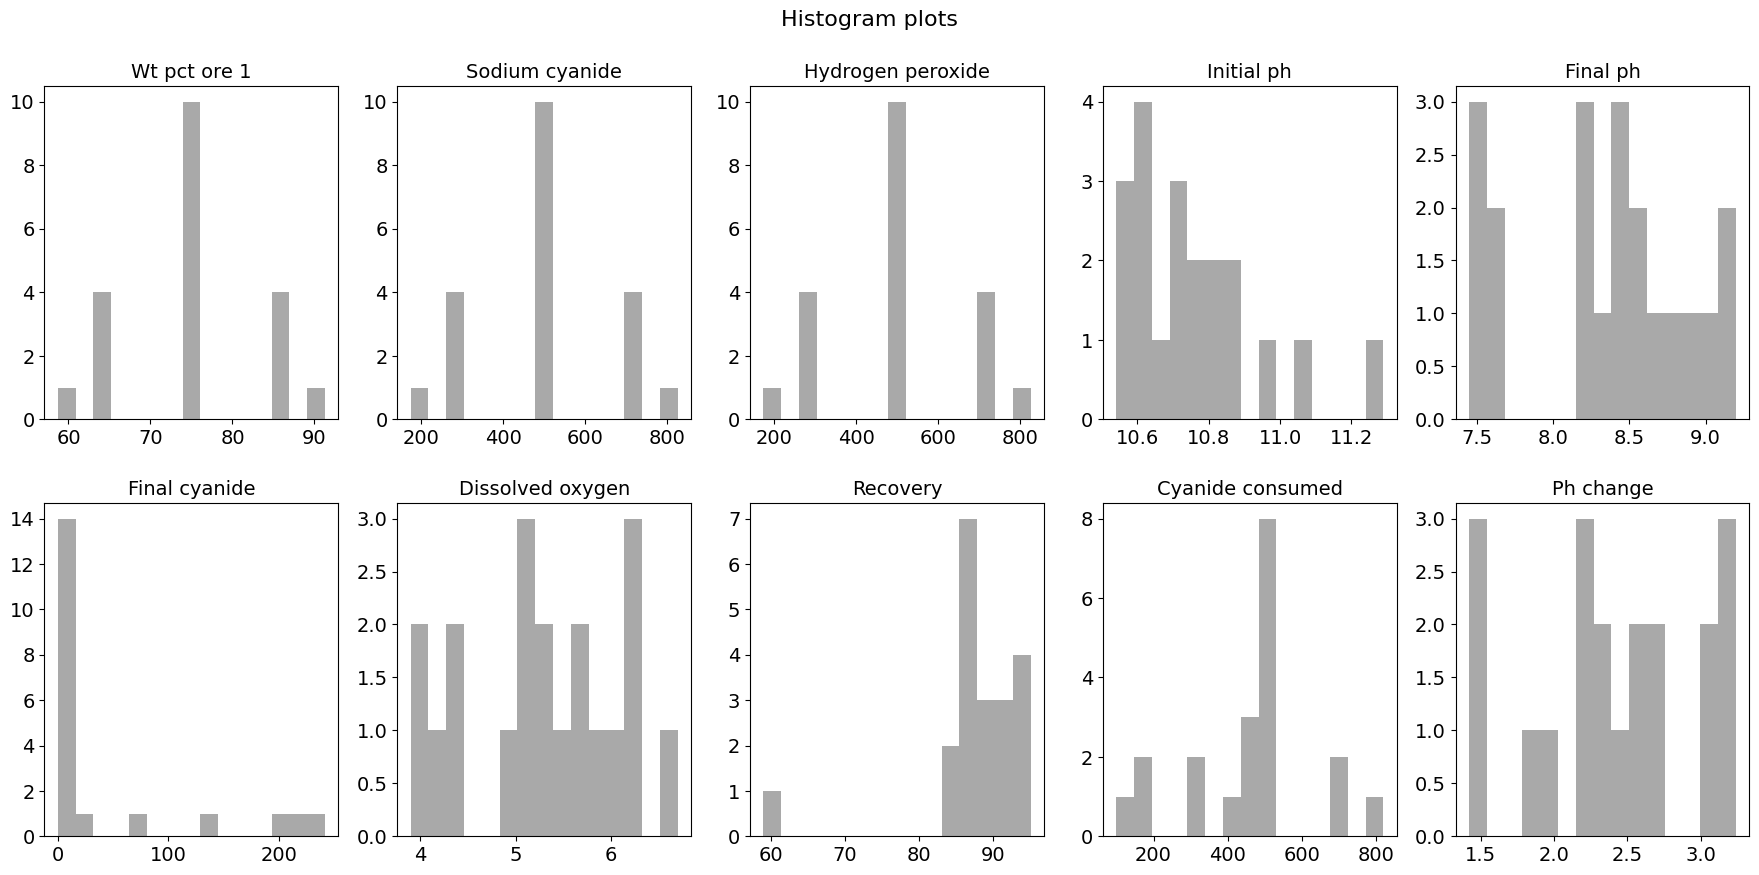

In [297]:
fig, axes = plt.subplots(2, 5, figsize=(22,9.5))
for col, ax in zip(df.columns, axes.flat):
  plt.sca(ax)
  plt.hist(df[col], bins=15, color="darkgray")
  plt.title(col.replace("_", " ").capitalize(), fontsize=14)
plt.suptitle("Histogram plots", fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.25)
plt.show()

The histogram plots reveal that the variables involved do not obey the Binomial distribution, and some of them (such as *Final cyanide*) are skewed. Since the most common statistical method assume normal dustribution of data, several techniques will be applied on the dataset in order to transform the data.

### **Data preparation**

#### Train and test sets
The histogram plot of gold recovery has shown that the data is skewed. It is therefore better to perform stratified sampling when creating the train set and test set; the test set will comprise 25% of all the data in the dataset.

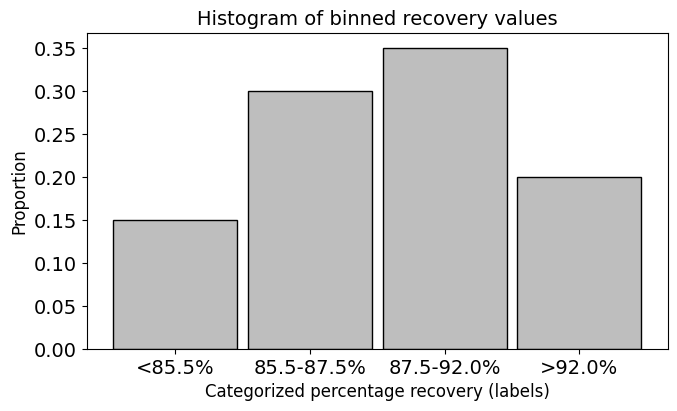

In [298]:
# Categorize gold recovery values into a more or less normal distribution
df["recovery_cat"] = pd.cut(df["recovery"],
                            bins=[0., 85.5, 87.5, 92., 100.1],  # Recovery values are floating-point values, hence, float values are used
                            labels=["<85.5%", "85.5-87.5%", "87.5-92.0%", ">92.0%"]
                            )

# Plot data distribution after categorization
plt.figure(figsize=(7.5,4.1))
sns.histplot(data=df, x="recovery_cat", stat="probability", discrete=True, shrink=0.92, color="darkgray")
plt.title("Histogram of binned recovery values", fontsize=14)
plt.xlabel("Categorized percentage recovery (labels)", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.show()

In [299]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)

for train_index, test_index in sss.split(X=df, y=df["recovery_cat"]):
  train = df.iloc[train_index]
  test = df.iloc[test_index]

In [300]:
# Having served its purpose, drop the "recovery_cat" column
all_datasets = (df, train, test)

for set_ in all_datasets:
  set_.drop("recovery_cat", axis=1, inplace=True)

X_train = train.drop("recovery", axis=1)
X_test = test.drop("recovery", axis=1)
y_train = train["recovery"].copy()
y_test = test["recovery"].copy()

clear_output()

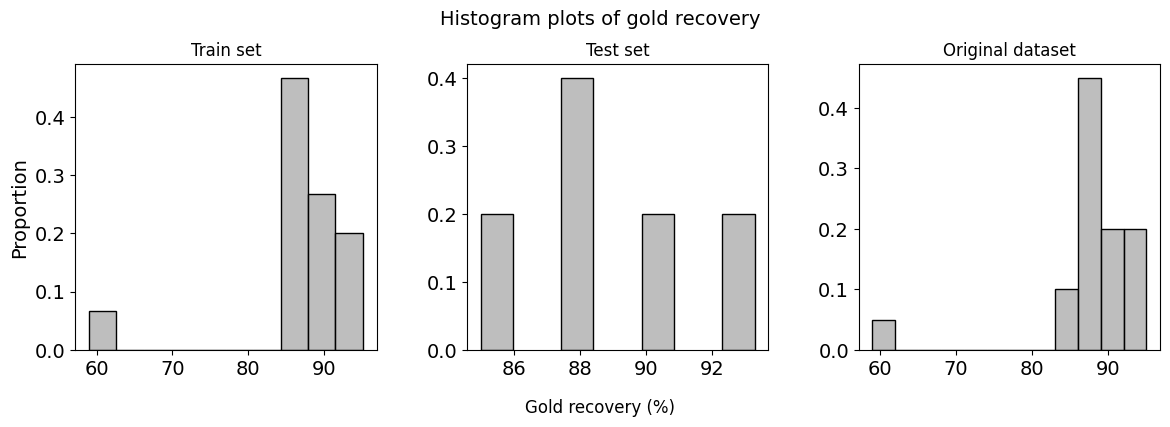

In [301]:
fig = plt.figure(figsize=(14,4.2))
plt.suptitle("Histogram plots of gold recovery", fontsize=14)
fig.supxlabel("Gold recovery (%)")
plt.subplot(131); sns.histplot(data=train["recovery"], stat="probability", color="darkgray"); plt.title("Train set", fontsize=12), plt.ylabel("Proportion"), plt.xlabel("")
plt.subplot(132); sns.histplot(data=test["recovery"], stat="probability", shrink=0.4, color="darkgray"), plt.title("Test set", fontsize=12), plt.ylabel(""), plt.xlabel("")
plt.subplot(133); sns.histplot(data=df["recovery"], stat="probability", color="darkgray"), plt.title("Original dataset", fontsize=12), plt.ylabel(""), plt.xlabel("")
plt.subplots_adjust(bottom=0.17, top=0.85, wspace=0.3)
plt.show()

With the help of stratified sampling, data points were effectively sampled to constitute the train and test sets, albeit the dataset is very small. However, the test set is the one that suffers significantly since only about one data point was sampled from the generated gold recovery categories.

### **Detection of outliers**

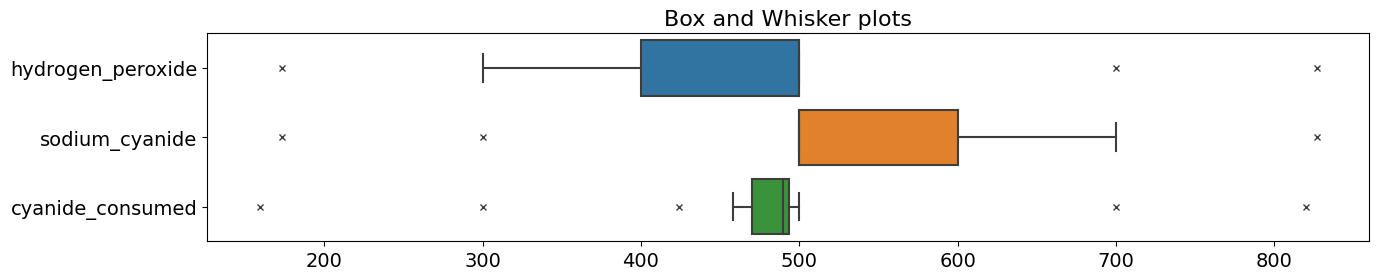

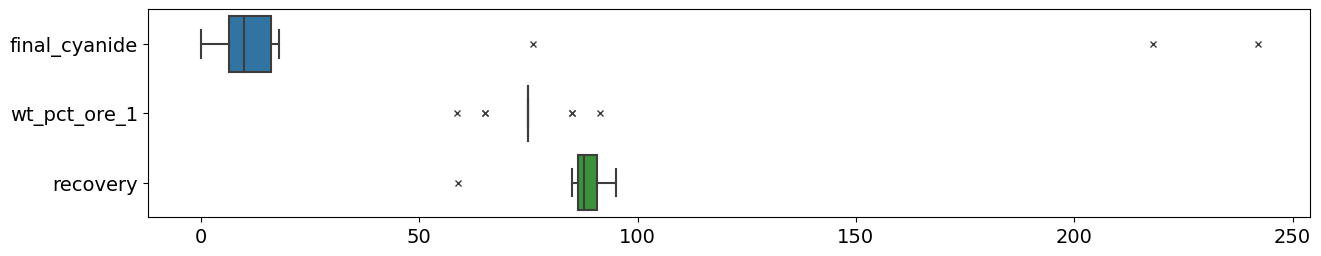

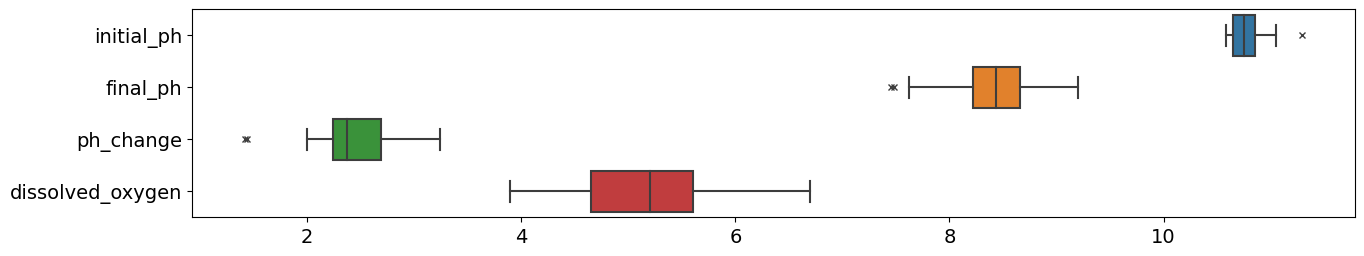

In [302]:
plt.figure(figsize=(15,2.7))
sns.boxplot(data=train[["hydrogen_peroxide", "sodium_cyanide", "cyanide_consumed"]],
            orient="h",
            flierprops={"marker": "x"}
            )
plt.title("Box and Whisker plots", fontsize=16)
plt.show()

print("\n")
plt.figure(figsize=(15,2.7))
sns.boxplot(data=train[["final_cyanide", "wt_pct_ore_1", "recovery"]],
            orient="h",
            flierprops={"marker": "x"}
            )
plt.show()

print("\n")
plt.figure(figsize=(15,2.7))
sns.boxplot(data=train[["initial_ph", "final_ph", "ph_change", "dissolved_oxygen"]],
            orient="h",
            flierprops={"marker": "x"}
            )
plt.show()

+ In the Box and Whisker plots above, the subplots of variables are grouped based on their range of values. A default value of *whis=1.5* was used in the function call *boxplot()* to define the maximum length of whiskers with respect to the Interquartile range (IQR) of each variable.
+ Note that some of the outliers shown in the boxplots of *sodium_cyanide*, *hydrogen_peroxide* and *wt_pct_ore_1* correspond to the axial (or star) points in the Central-Composite Design (CCD) of the experiments.
+ Since the dataset is very small and the number of outliers is negligible, they will be ignored. Therefore, these outliers will not be processed for transformation or dropping from the dataset.

### **Relationship between dependent variables and the response variable**

#### Raw data

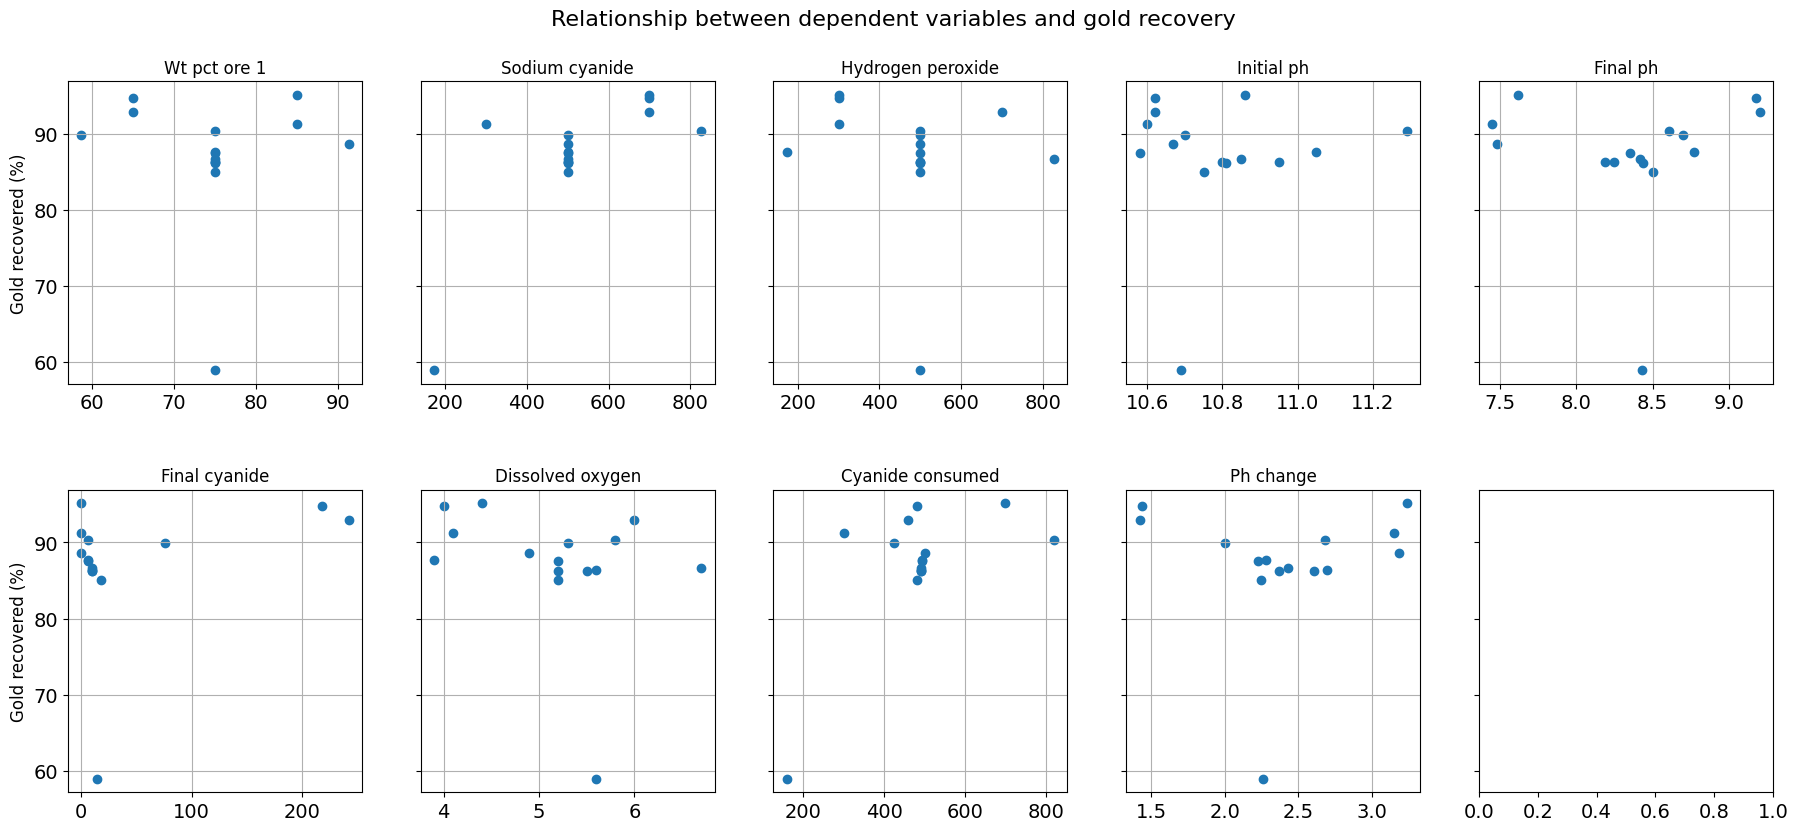

In [303]:
fig, axes = plt.subplots(2, 5, sharey=True, figsize=(22,9))
for col, ax in zip(X_train.columns, axes.flat):
  plt.sca(ax)
  plt.scatter(X_train[col], y_train)
  plt.title(col.replace("_", " ").capitalize(), fontsize=12)
  if col == "wt_pct_ore_1" or col == "final_cyanide":
    plt.ylabel("Gold recovered (%)", fontsize=12)
  plt.grid()
plt.suptitle("Relationship between dependent variables and gold recovery", fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.35)
plt.show()

+ The lowest gold recovery correponds to the experimental run with the lowest concentration of sodium cyanide. This shows the significant effect of sodium cyanide in gold leaching.

#### Main effects plots

In [304]:
# Compute average gold recovery values for each level, for each variable
def main_effects(data, x, y):
  return data.groupby([x])[y].mean()

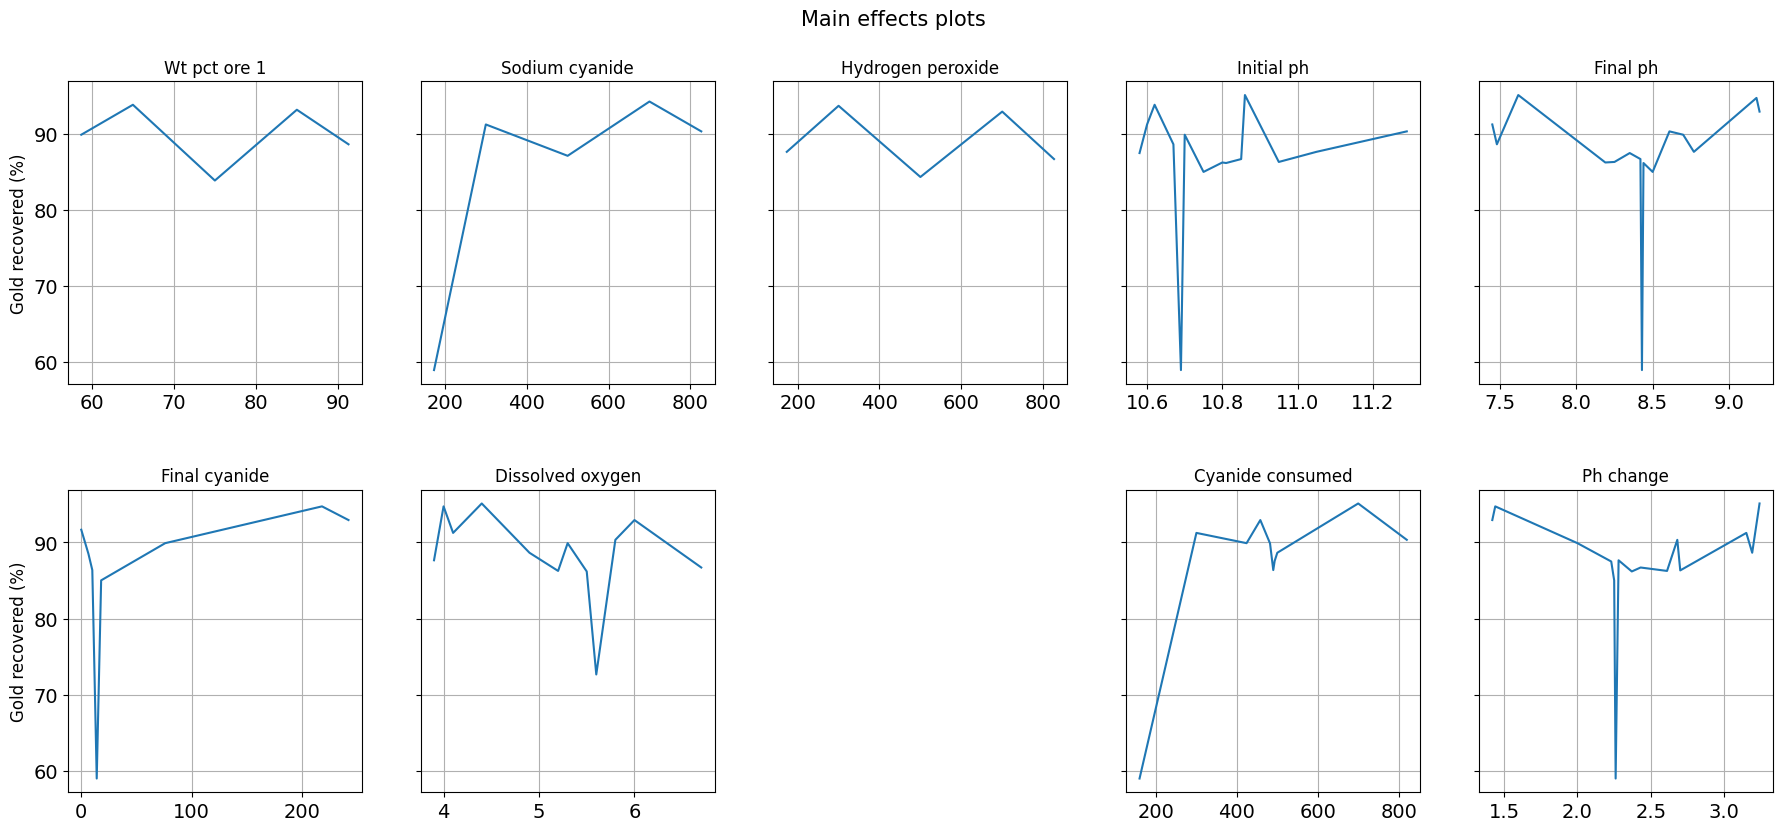

In [305]:
fig, axes = plt.subplots(2, 5, sharey=True, figsize=(22,9))
for col, ax in zip(train.columns, axes.flat):
  plt.sca(ax)
  if col == "recovery":
    plt.axis("off")
    continue
  out_ = main_effects(train, col, "recovery")
  plt.plot(out_)
  plt.title(col.replace("_", " ").capitalize(), fontsize=12)
  if col=="wt_pct_ore_1" or col=="final_cyanide":
    ax.set_ylabel("Gold recovered (%)", fontsize=12)
  plt.grid()
plt.suptitle("Main effects plots", fontsize=15)
plt.subplots_adjust(top=0.9, hspace=0.35)
plt.show()

### **Linear Correlation**

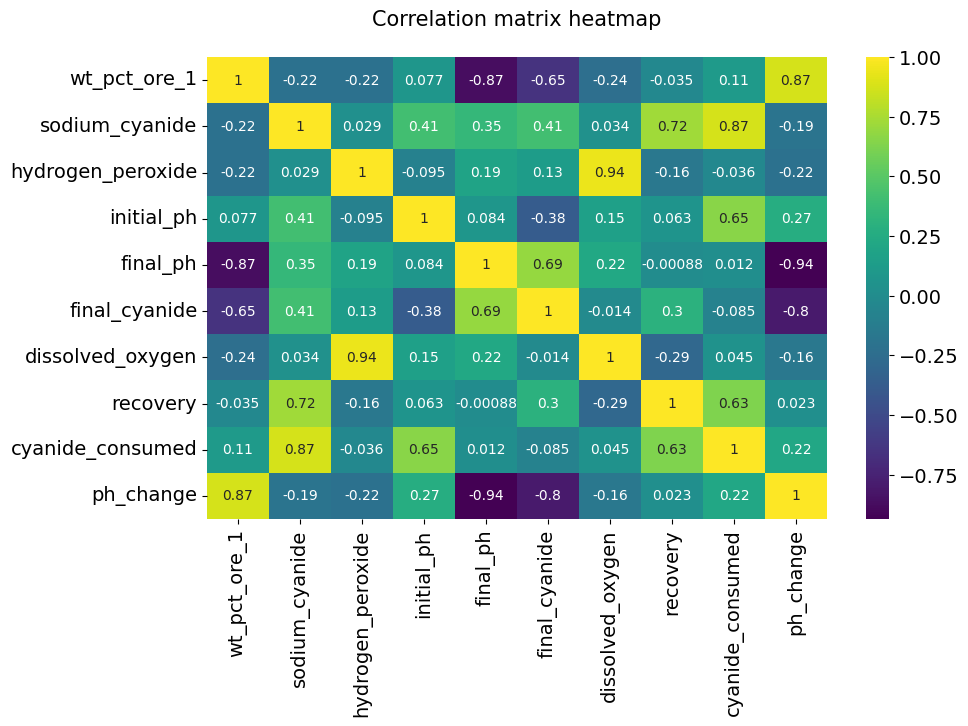

In [306]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), cmap="viridis", annot=True)
plt.title("Correlation matrix heatmap\n", fontsize=15)
plt.show()

+ The heatmap of the correlation matrix reveals some interesting results:
  + foremost, as stated before, there is a strong correlation between the parent variables and their derived variables: sodium_cyanide and cyanide_consumed, and ph variables (initial_ph, final_ph, and ph_change).These correlations can be ignored.
  + a strong linear correlation exist between the content of gold ore sample 1 in the ore blend and the amount of pH reagent consumed in the leahching tests (see wt_pct_ore_1 vs final_ph (negative correlation), and wt_pct_ore_1 and ph_change (positive correlation)).
  + the obvious strong correlation (= 0.72) exist between sodium cyanide reagent and the amount of gold recovered. Cyanude species are well known to be one of the major drivers of gold cyanidation processes.
  + the effect of dissolved oxygen in the leach slurry is clear as shown by the strong correlation (= 0.94) between the dissolved_oxygen and dissolved_oxygen concentration in the slurry.
  +  there was a weak correlation between the pH variables (initial_ph, final_ph, and ph_change) and gold recovery.
  + the relationship between dissolved_oxygen concentration and gold recovery is marked with a weak linear correlation (= 0.29), which implies that higher concentrations of dissolved oxygen have detrimental effect to gold recovery, possibly due to coating of gold/ gold-bearing particles by oxygen molecules.
  + finally, the amount of cyanide species consumed in a leaching test have a moderately strong positive correlation (= 0.63) on gold recovery.

## **Preparation of data for model training**

In [307]:
num_features = np.array(X_train.columns)

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("std_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num_pipeline", pipeline, num_features),
    ], remainder="passthrough"
)

In [308]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

# Shape of X_train_prepared
X_train_prepared.shape

(15, 9)

## **Deep Learning**

In [309]:
model = models.Sequential([
    layers.Flatten(input_shape=(9,), name="input_"),
    layers.Dense(50, activation="relu", name="hidden_1"),
    layers.Dense(30, activation="relu", name="hidden_2"),
    layers.Dense(1, name="output_"),
], name="Sequential_model")

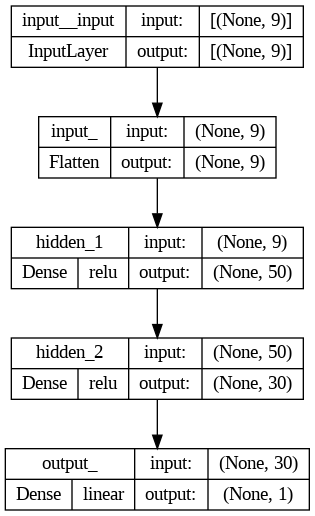

In [310]:
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_activations=True
                       )

In [311]:
model.summary()

Model: "Sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ (Flatten)            (None, 9)                 0         
                                                                 
 hidden_1 (Dense)            (None, 50)                500       
                                                                 
 hidden_2 (Dense)            (None, 30)                1530      
                                                                 
 output_ (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,061
Trainable params: 2,061
Non-trainable params: 0
_________________________________________________________________


In [312]:
model.save("gold_cyanidation_model.h5")

In [313]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=5.5e-4, momentum=0.9, nesterov=True))
history = model.fit(X_train_prepared, y_train, epochs=150)

Epoch 1/150
1/1 [==============================] - 1s 828ms/step - loss: 7719.0415
Epoch 2/150
1/1 [==============================] - 0s 15ms/step - loss: 7550.7935
Epoch 3/150
1/1 [==============================] - 0s 14ms/step - loss: 7307.6577
Epoch 4/150
1/1 [==============================] - 0s 13ms/step - loss: 6845.5825
Epoch 5/150
1/1 [==============================] - 0s 10ms/step - loss: 5741.3853
Epoch 6/150
1/1 [==============================] - 0s 14ms/step - loss: 3041.8538
Epoch 7/150
1/1 [==============================] - 0s 13ms/step - loss: 1480.0564
Epoch 8/150
1/1 [==============================] - 0s 12ms/step - loss: 432.1678
Epoch 9/150
1/1 [==============================] - 0s 12ms/step - loss: 305.7360
Epoch 10/150
1/1 [==============================] - 0s 18ms/step - loss: 107.4117
Epoch 11/150
1/1 [==============================] - 0s 13ms/step - loss: 59.4521
Epoch 12/150
1/1 [==============================] - 0s 13ms/step - loss: 27.3645
Epoch 13/150
1/1 [=

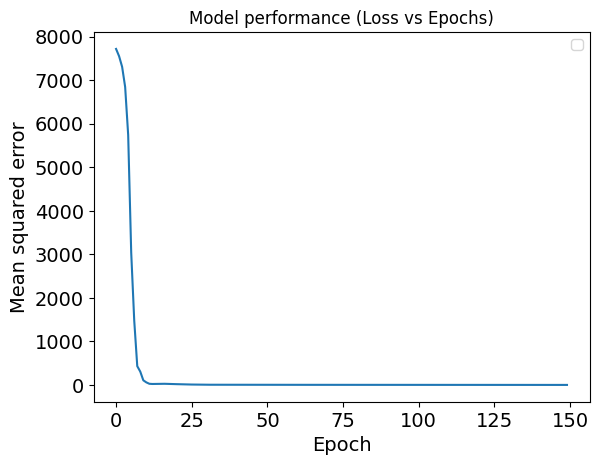

In [314]:
pd.DataFrame(history.history).plot()
plt.title("Model performance (Loss vs Epochs)")
plt.ylabel("Mean squared error")
plt.xlabel("Epoch")
plt.legend("")
plt.show()

In [315]:
model.evaluate(X_test_prepared, y_test)

1/1 [==============================] - 1s 542ms/step - loss: 161.1924


161.1924285888672

1/1 [==============================] - 0s 270ms/step


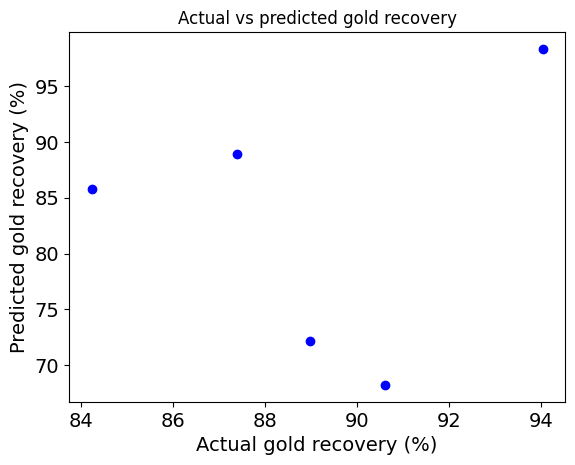

In [316]:
y_pred = model.predict(X_test_prepared)

plt.plot(y_test, y_pred, "bo")
plt.title("Actual vs predicted gold recovery")
plt.ylabel("Predicted gold recovery (%)")
plt.xlabel("Actual gold recovery (%)")
plt.show()

In [317]:
y_test

13    87.39
18    90.61
16    84.24
11    94.03
8     88.97
Name: recovery, dtype: float64